In [1]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator, FuncFormatter
import itertools
import json
import numpy as np
from pylhe import read_lhe_with_attributes, read_num_events
import itertools
import json
import math
import vector
import mplhep as hep
from scipy.optimize import curve_fit
import os
import pandas as pd

## Functions

## Importing data

In [2]:
import json

# Path to the combined JSON file
combined_file_path = r"..\..\DataFiles\combined_data.json"

# Read the JSON file
with open(combined_file_path, 'r') as file:
    data = json.load(file) 



In [9]:
print("Keys in the JSON data:", data.keys())

Keys in the JSON data: dict_keys(['100.0', '13.0', '13.6', '14.0', '20.0', '50.0', '70.0'])


In [11]:
# Inspect the nested structure of the data
for key, value in data.items():
    print(f"Key: {key}")
    print(f"Type of value: {type(value)}")
    
    # If the value is also a dictionary, print its keys
    if isinstance(value, dict):
        print(f"Nested keys under '{key}': {value.keys()}")
    elif isinstance(value, list):
        print(f"Length of list under '{key}': {len(value)}")
        if len(value) > 0:
            print(f"Type of first item in list under '{key}': {type(value[0])}")
    else:
        print(f"Value under '{key}': {value}")
    
    print("-" * 40)  # Separator for clarity

Key: 100.0
Type of value: <class 'dict'>
Nested keys under '100.0': dict_keys(['W-', 'W+', 'Z'])
----------------------------------------
Key: 13.0
Type of value: <class 'dict'>
Nested keys under '13.0': dict_keys(['W-', 'W+', 'Z'])
----------------------------------------
Key: 13.6
Type of value: <class 'dict'>
Nested keys under '13.6': dict_keys(['W-', 'W+', 'Z'])
----------------------------------------
Key: 14.0
Type of value: <class 'dict'>
Nested keys under '14.0': dict_keys(['W-', 'W+', 'Z'])
----------------------------------------
Key: 20.0
Type of value: <class 'dict'>
Nested keys under '20.0': dict_keys(['W-', 'W+', 'Z'])
----------------------------------------
Key: 50.0
Type of value: <class 'dict'>
Nested keys under '50.0': dict_keys(['W-', 'W+', 'Z'])
----------------------------------------
Key: 70.0
Type of value: <class 'dict'>
Nested keys under '70.0': dict_keys(['W-', 'W+', 'Z'])
----------------------------------------


In [12]:
# Inspect deeper levels of the nested structure
for top_key, top_value in data.items():
    print(f"Top-level key: {top_key}")
    if isinstance(top_value, dict):
        for mid_key, mid_value in top_value.items():
            print(f"  Nested key under '{top_key}': {mid_key}")
            print(f"  Type of value: {type(mid_value)}")
            
            # If the value is another dictionary, print its keys
            if isinstance(mid_value, dict):
                print(f"    Further nested keys under '{mid_key}': {mid_value.keys()}")
            elif isinstance(mid_value, list):
                print(f"    List length under '{mid_key}': {len(mid_value)}")
                if len(mid_value) > 0:
                    print(f"    Type of first item in list under '{mid_key}': {type(mid_value[0])}")
            else:
                print(f"    Value under '{mid_key}': {mid_value}")
            
            print("-" * 40)
    else:
        print(f"Value under '{top_key}': {top_value}")
    print("=" * 40)


Top-level key: 100.0
  Nested key under '100.0': W-
  Type of value: <class 'dict'>
    Further nested keys under 'W-': dict_keys(['Energy', 'px', 'py', 'pz', 'Decay Angle'])
----------------------------------------
  Nested key under '100.0': W+
  Type of value: <class 'dict'>
    Further nested keys under 'W+': dict_keys(['Energy', 'px', 'py', 'pz', 'Decay Angle'])
----------------------------------------
  Nested key under '100.0': Z
  Type of value: <class 'dict'>
    Further nested keys under 'Z': dict_keys(['Energy', 'px', 'py', 'pz', 'Decay Angle'])
----------------------------------------
Top-level key: 13.0
  Nested key under '13.0': W-
  Type of value: <class 'dict'>
    Further nested keys under 'W-': dict_keys(['Energy', 'px', 'py', 'pz', 'Decay Angle'])
----------------------------------------
  Nested key under '13.0': W+
  Type of value: <class 'dict'>
    Further nested keys under 'W+': dict_keys(['Energy', 'px', 'py', 'pz', 'Decay Angle'])
-----------------------------

## $P_T$ functions

In [35]:
def calculate_transverse_momentum(data, energy_level, boson_type):
    """
    Calculate the transverse momentum (P_t) for a given boson at a specific energy level.
    Optimized for large datasets using NumPy.
    
    Parameters:
        data (dict): The JSON data loaded into a Python dictionary.
        energy_level (float): The energy level key to access (e.g., 100.0).
        boson_type (str): The boson type to access ('W-', 'W+', or 'Z').
    
    Returns:
        np.ndarray: Array of transverse momentum values. Returns None if invalid input.
    """
    # Convert energy level to a string key since JSON keys are strings
    energy_key = str(energy_level)
    
    # Check if the energy level exists in the data
    if energy_key not in data:
        print(f"Error: Energy level {energy_level} not found.")
        return None
    
    # Check if the boson type exists under the given energy level
    if boson_type not in data[energy_key]:
        print(f"Error: Boson type '{boson_type}' not found under energy level {energy_level}.")
        return None
    
    # Access the px and py values for the specified boson
    boson_data = data[energy_key][boson_type]
    px = np.array(boson_data.get('px', []))  # Convert to NumPy array
    py = np.array(boson_data.get('py', []))  # Convert to NumPy array
    
    # Ensure px and py are of the same length
    if px.shape != py.shape:
        print("Error: px and py arrays have different lengths.")
        return None
    
    # Vectorized calculation of transverse momentum
    pt = np.sqrt(px**2 + py**2)
    return pt


In [36]:
def plot_pt_histograms_all_energies(data, boson_type, pt_bin_width=10):
    """
    Plot a single histogram with transverse momentum distributions for a specific boson type across all energy levels.
    Each energy level is represented by a distinct line on the plot.

    Parameters:
    - data: The combined JSON data containing boson information for multiple energies.
    - boson_type: The type of boson ('W-', 'W+', 'Z') being studied (for the plot title).
    - pt_bin_width: Width of the bins in transverse momentum units (default: 10 GeV).
    """
    # Extract all energy levels from the data
    all_energies = [float(key) for key in data.keys()]
    all_energies.sort()

    # Compute transverse momentum arrays for all energy levels
    all_pt_arrays = [calculate_transverse_momentum(data, energy, boson_type) for energy in all_energies]

    # Find the global maximum value across all PT arrays
    global_max_pt = max([np.max(pt_data) for pt_data in all_pt_arrays if len(pt_data) > 0])

    # Define bin edges for the entire range based on pt_bin_width
    bin_edges = np.arange(0, global_max_pt + pt_bin_width, pt_bin_width)

    # Set up the figure and axis
    fig, ax = plt.subplots(figsize=(10, 6))

    # Define colors for the histograms
    colors = plt.cm.viridis(np.linspace(0, 1, len(all_pt_arrays)))

    # Loop through each PT array and corresponding energy to plot the histograms
    for i, (pt_data, energy) in enumerate(zip(all_pt_arrays, all_energies)):
        if len(pt_data) > 0:  # Ensure there is data to plot
            # Compute histogram data with the defined constant bin widths
            counts, _ = np.histogram(pt_data, bins=bin_edges)

            # Plot histogram as a step outline
            ax.step(bin_edges[:-1], counts, where='post',
                    label=f"$\\sqrt{{s}} = {energy:.1f} \\, \\mathrm{{TeV}}$", color=colors[i], linewidth=1.5)

    # Customize plot
    ax.set_xlim(0, 1000)
    ax.set_xlabel("Transverse Momentum [GeV]", fontsize=14)
    ax.set_ylabel("Counts", fontsize=14)
    ax.set_title(f"Transverse Momentum Distributions for {boson_type} Boson", fontsize=16)
    ax.legend(title="Center-of-Mass Energy", loc="upper right", fontsize=10)
    ax.grid(alpha=0.6)

    # Show the plot
    plt.tight_layout()
    plt.show()


## Helicity Fractions Functions

## Pseudorapidity Functions

In [49]:
def calculate_pseudorapidity(data, energy_level, boson_type):
    """
    Calculate the pseudorapidity for a given boson at a specific energy level.
    Optimized for large datasets using NumPy.
    
    Parameters:
        data (dict): The JSON data loaded into a Python dictionary.
        energy_level (float): The energy level key to access (e.g., 100.0).
        boson_type (str): The boson type to access ('W-', 'W+', or 'Z').
    
    Returns:
        np.ndarray: Array of pseudorapidity values. Returns an empty array if invalid input.
    """
    # Convert energy level to a string key since JSON keys are strings
    energy_key = str(energy_level)
    
    # Check if the energy level and boson type exist in the data
    if energy_key not in data or boson_type not in data[energy_key]:
        return np.array([])  # Return an empty array if no valid data exists
    
    # Access the px, py, and pz values for the specified boson
    boson_data = data[energy_key][boson_type]
    px = np.array(boson_data.get('px', []))
    py = np.array(boson_data.get('py', []))
    pz = np.array(boson_data.get('pz', []))
    
    # Check if all arrays have the same shape
    if not (px.shape == py.shape == pz.shape):
        return np.array([])  # Return an empty array if the data is inconsistent
    
    # Vectorized calculation of pseudorapidity
    transverse_momentum = np.sqrt(px**2 + py**2)
    eta = -np.log(np.tan(0.5 * np.arctan2(transverse_momentum, pz)))
    
    return eta


In [67]:
def plot_eta_histograms_all_energies(data, boson_type, eta_bin_width=0.1):
    """
    Plot a single histogram with pseudorapidity distributions for a specific boson type across all energy levels.
    Each energy level is represented by a distinct line on the plot.

    Parameters:
    - data: The combined JSON data containing boson information for multiple energies.
    - boson_type: The type of boson ('W-', 'W+', 'Z') being studied (for the plot title).
    - eta_bin_width: Width of the bins in pseudorapidity units (default: 0.1).
    """
    # Extract all energy levels from the data
    all_energies = [float(key) for key in data.keys()]
    all_energies.sort()

    # Compute pseudorapidity arrays for all energy levels
    all_eta_arrays = [calculate_pseudorapidity(data, energy, boson_type) for energy in all_energies]

    # Filter out empty arrays to avoid errors
    all_eta_arrays = [eta_data for eta_data in all_eta_arrays if len(eta_data) > 0]

    # Check if there's any data to plot
    if not all_eta_arrays:
        print(f"No valid data to plot for boson type {boson_type}.")
        return

    # Find the global maximum and minimum values across all eta arrays
    global_min_eta = min([np.min(eta_data) for eta_data in all_eta_arrays])
    global_max_eta = max([np.max(eta_data) for eta_data in all_eta_arrays])

    # Define bin edges for the entire range based on eta_bin_width
    bin_edges = np.arange(global_min_eta, global_max_eta + eta_bin_width, eta_bin_width)

    # Set up the figure and axis
    fig, ax = plt.subplots(figsize=(10, 6))

    # Define colors for the histograms
    colors = plt.cm.viridis(np.linspace(0, 1, len(all_eta_arrays)))

    # Loop through each eta array and corresponding energy to plot the histograms
    for i, (eta_data, energy) in enumerate(zip(all_eta_arrays, all_energies)):
        # Compute histogram data with the defined constant bin widths
        counts, _ = np.histogram(eta_data, bins=bin_edges)

        # Plot histogram as a step outline
        ax.step(bin_edges[:-1], counts, where='post',
                label=f"$\\sqrt{{s}} = {energy:.1f} \\, \\mathrm{{TeV}}$", color=colors[i], linewidth=1.5)

    # Customize plot
    ax.set_xlim(global_min_eta, global_max_eta)
    ax.set_ylim(0,9000)
    ax.set_xlabel("Pseudorapidity (η)", fontsize=14)
    ax.set_ylabel("Counts", fontsize=14)
    ax.set_title(rf"Pseudorapidity Distributions for {boson_type} Boson", fontsize=16)
    ax.legend(title="Center-of-Mass Energy", loc="upper right", fontsize=10)
    ax.grid(alpha=0.6)

    # Show the plot
    plt.tight_layout()
    plt.show()


## P

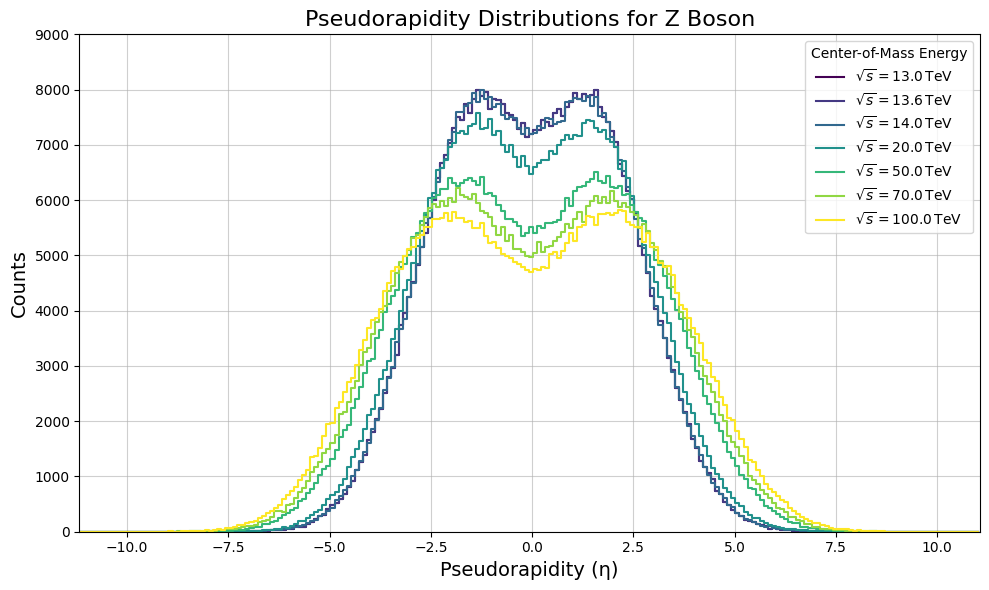

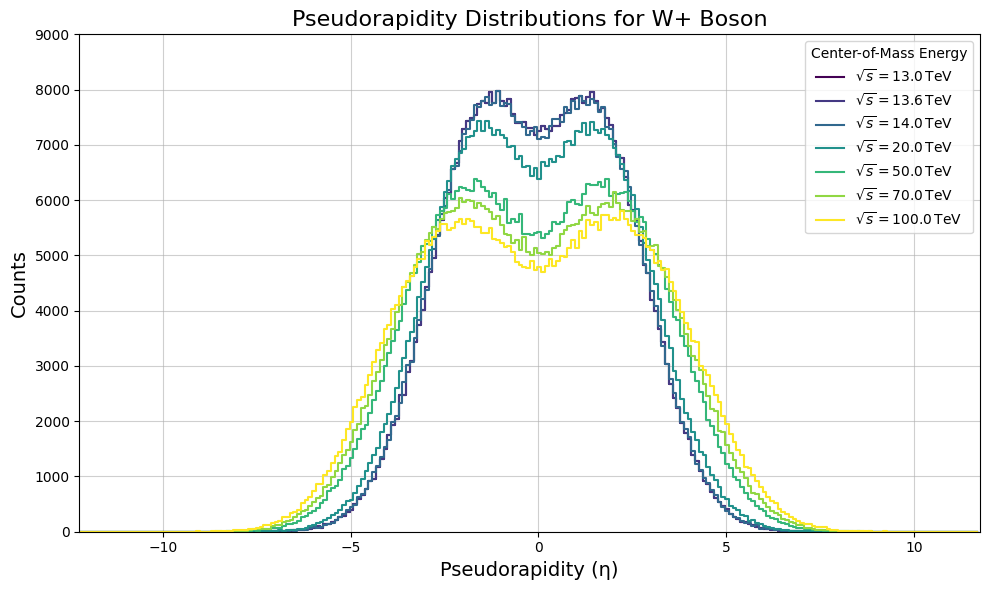

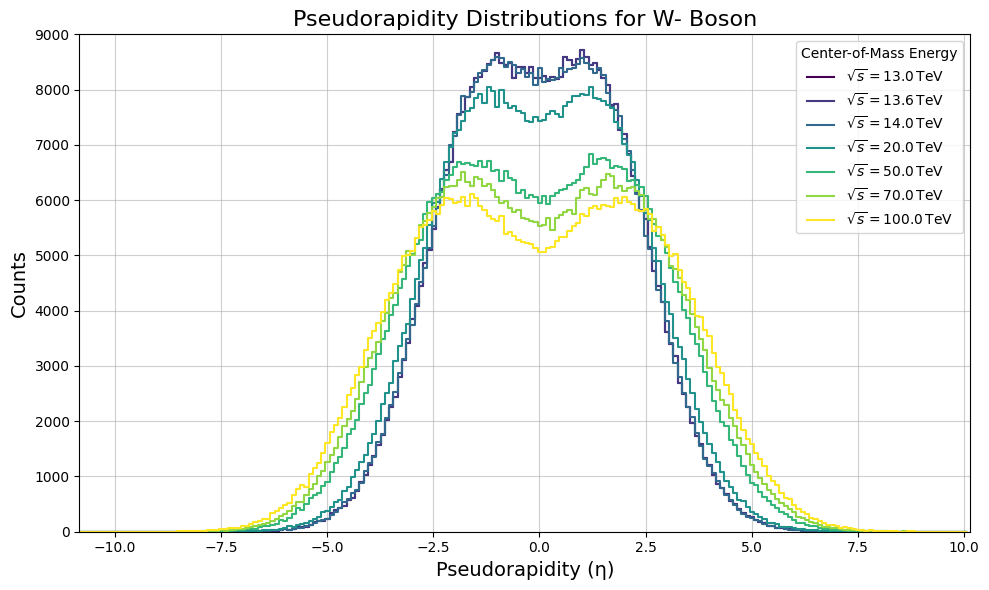

In [68]:
plot_eta_histograms_all_energies(data, "Z")
plot_eta_histograms_all_energies(data, "W+")
plot_eta_histograms_all_energies(data, "W-")

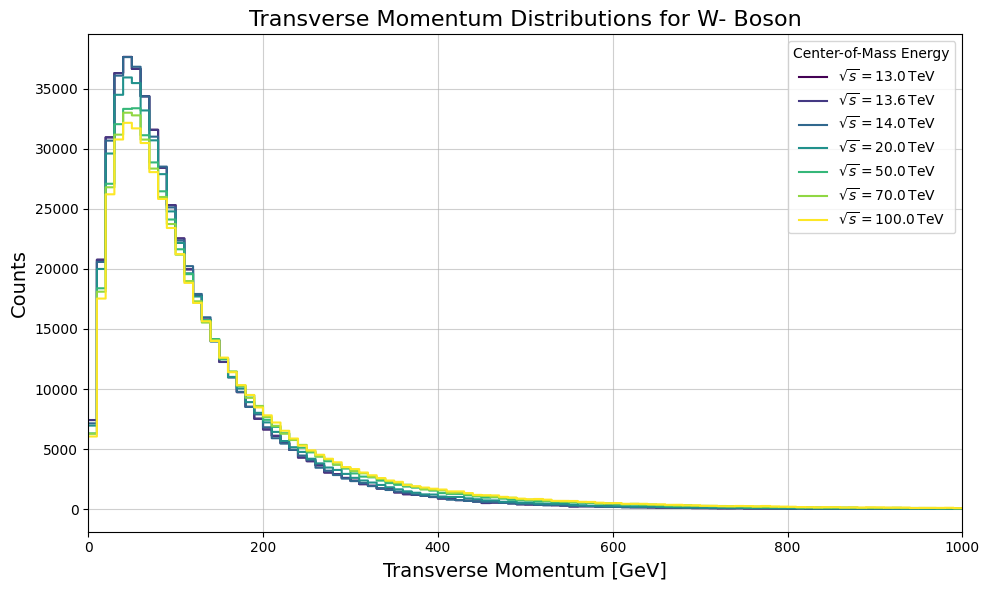

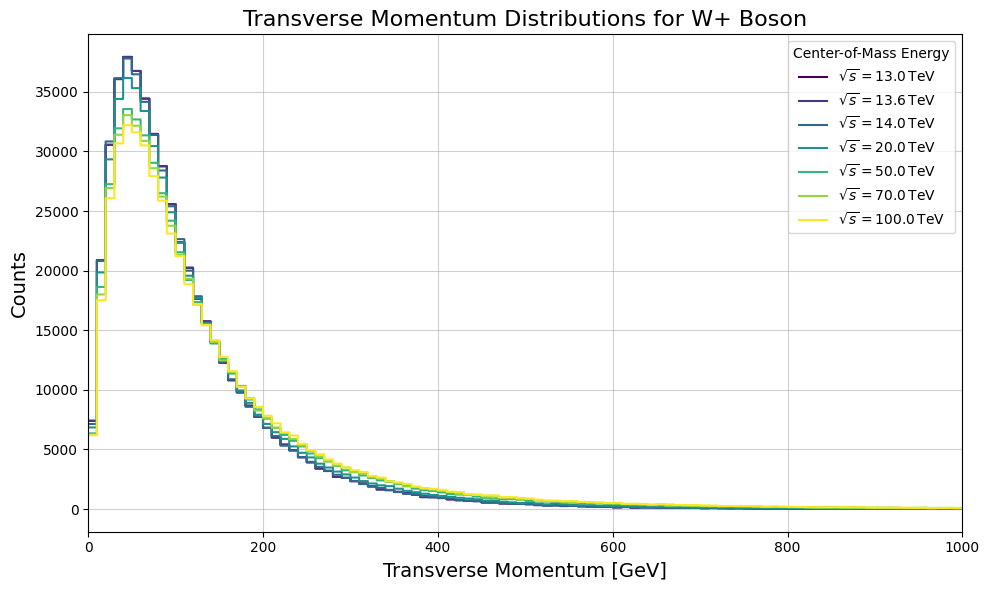

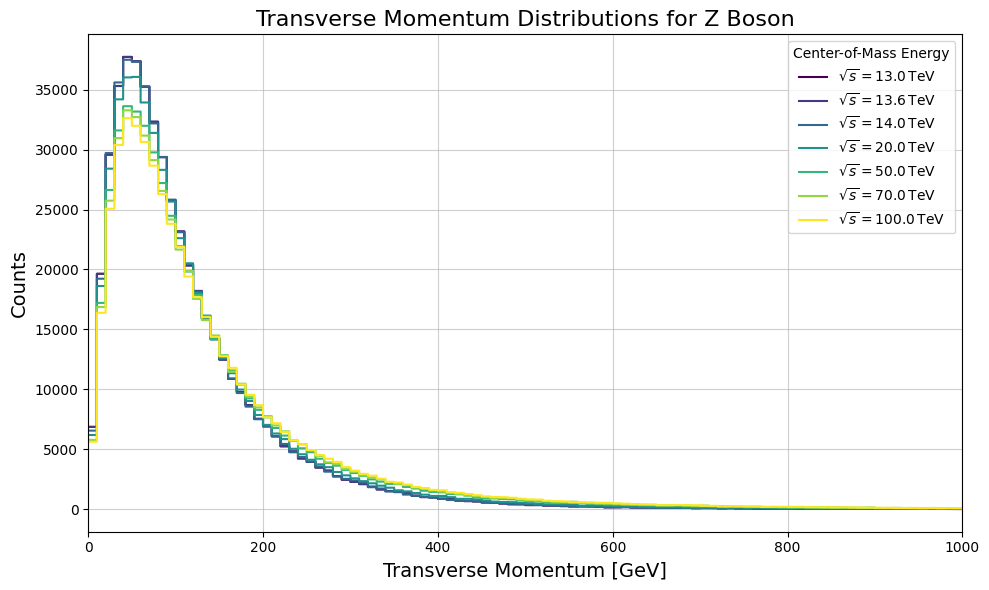

In [32]:
plot_pt_histograms_all_energies(data=data, boson_type="W-")

# Plot for W+ boson
plot_pt_histograms_all_energies(data=data, boson_type="W+")

# Plot for Z boson
plot_pt_histograms_all_energies(data=data, boson_type="Z")